# cDCGAN (conditional Deep Convolutional Generative Adversarial Network)
Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality. Class labels can also be used for the deliberate or targeted generation of images of a given type.

There are many ways to encode and incorporate the class labels into the discriminator and generator models. A best practice involves using an embedding layer followed by a fully connected layer with a linear activation that scales the embedding to the size of the image before concatenating it in the model as an additional channel or feature map. The class labels are one hot encoded and concatenated with the input to both the generator and discriminator models.

#### Training normal GAN
GAN model takes as input a point in the latent space, uses the generator model to generate an image which is fed as input to the discriminator model, then is output or classified as real or fake.
(point --> generator --> image --> discriminator --> real/fake)

In [3]:
from tensorflow.keras.utils import plot_model

In [4]:
from numpy import ones, expand_dims
from numpy.random import randint

# loading the dataset
def load_real_samples():

    (train_X, train_y), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(train_X, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5

    # return loaded and scaled Fashion MNIST training dataset ready for modeling.
    return [X, train_y] 

# selecting a batch of real samples
def generate_real_samples(dataset, n_samples):
    
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    
    return [X, labels], y

Generate an array of randomly selected integer class labels to go along with the randomly selected points in the latent space.

In [5]:
from numpy.random import randn

def generate_latent_points(latent_dim, n_samples, n_classes):

    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    
    # generate labels
    labels = randint(0, n_classes, n_samples)
 
    return [z_input, labels]

Use the generator to generate(predict) n fake examples, with class labels

In [31]:
from numpy import zeros

def generate_fake_samples(generator, latent_dim, n_samples):
   
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_classes=10)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    
    # create class labels
    y = zeros((n_samples, 1))
    
    return [images, labels_input], y

### cGAN architecture overview

![cGAN_architecture-2.png](attachment:cGAN_architecture-2.png)

## Discriminator

The class label is then passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the Fashion MNIST dataset (0 through 9) will map to a different 50-element vector representation that will be learned by the discriminator model.

In [7]:
from tensorflow.keras.layers import Input, LeakyReLU, Dropout, Embedding, Concatenate
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def define_discriminator(input_shape, n_classes):
    
    # label input
    class_label = Input(shape=(1,))
    # embedding for categorical input
    x = Embedding(n_classes, 5*n_classes)(class_label)
    
    # scale up to image dimensions with linear activation
    n_nodes = input_shape[0] * input_shape[1]
    x = Dense(n_nodes)(x)
    # reshape to additxional channel
    x = Reshape((input_shape[0], input_shape[1], 1))(x)
    
    # image input
    input_image = Input(shape=input_shape)
    # concat label as a channel
    merge = Concatenate()([input_image, x])
    
    # downsample
    y = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    y = LeakyReLU(alpha=0.2)(y)
    # downsample
    y = Conv2D(128, (3,3), strides=(2,2), padding='same')(y)
    y = LeakyReLU(alpha=0.2)(y)
    
    # flatten feature maps
    y = Flatten()(y)
    # dropout
    y = Dropout(0.4)(y)
    
    # output
    output_layer = Dense(1, activation='sigmoid')(y)
    # define model
    model = Model([input_image, class_label], output_layer)
    
    return model

In [8]:
# create the discriminator
discriminator = define_discriminator(input_shape=(28,28,1), n_classes=10)

# compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________________

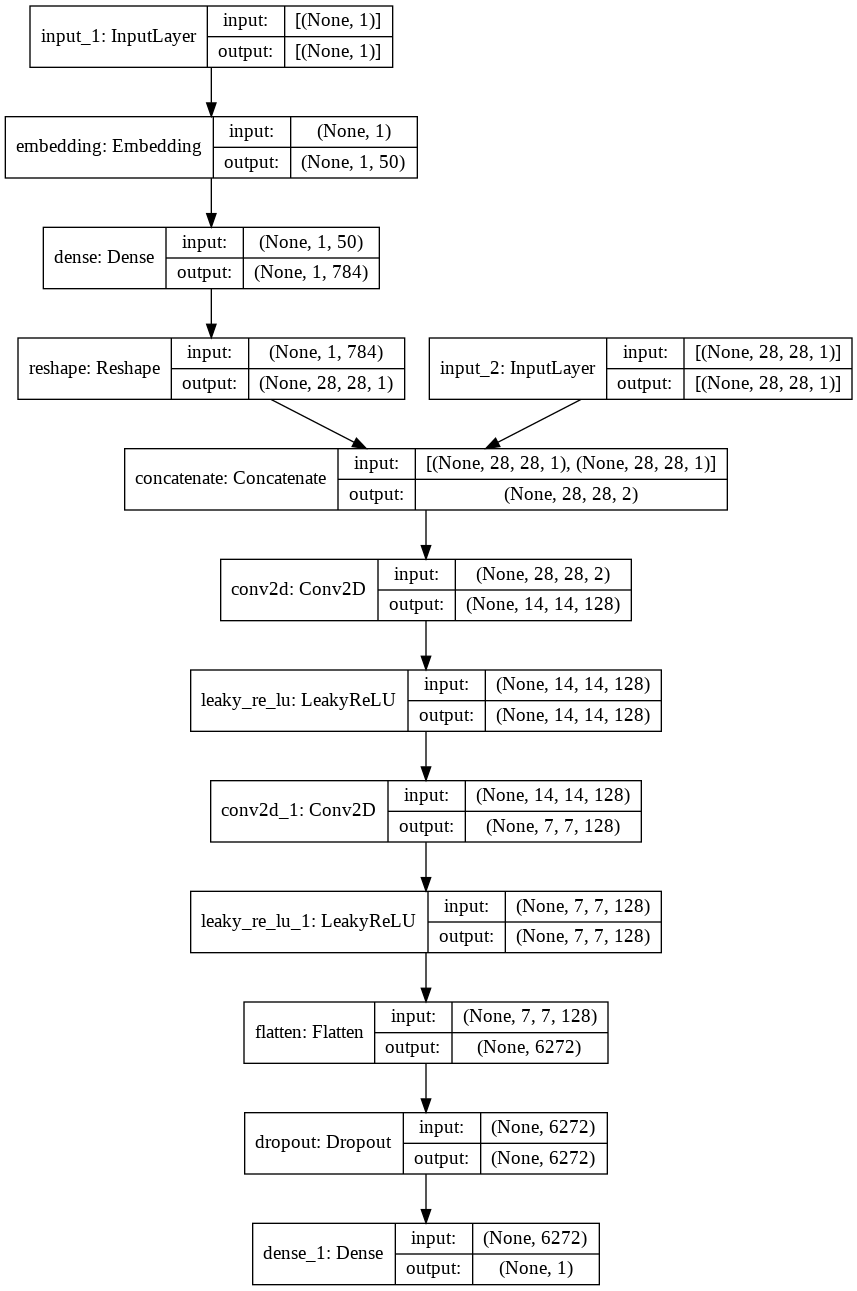

In [9]:
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## Generator

Next, the generator model must be updated to take the class label. This has the effect of making the point in the latent space conditional on the provided class label.
In this case, the activations of the fully connected layer are resized into a single 7×7 feature map. The new 7×7 feature map is added as one more channel to the existing 128, resulting in 129 feature maps that are then upsampled as in the prior model

In [10]:
def define_generator(latent_dim, n_classes):
    
    # label input
    class_label = Input(shape=(1,))
    # embedding for categorical input
    x = Embedding(n_classes, 5*n_classes)(class_label)
    
    # linear multiplication
    n_nodes = 7 * 7
    x = Dense(n_nodes)(x)
    # reshape to additional channel
    x = Reshape((7, 7, 1))(x)
    
    # image generator input
    latent_input = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(latent_input)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, x])
    
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # output
    output_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)   #[-1,1]
    # define model
    model = Model([latent_input, class_label], output_layer)
    
    return model

In [11]:
# create the generator
generator = define_generator(latent_dim=100,n_classes=10)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

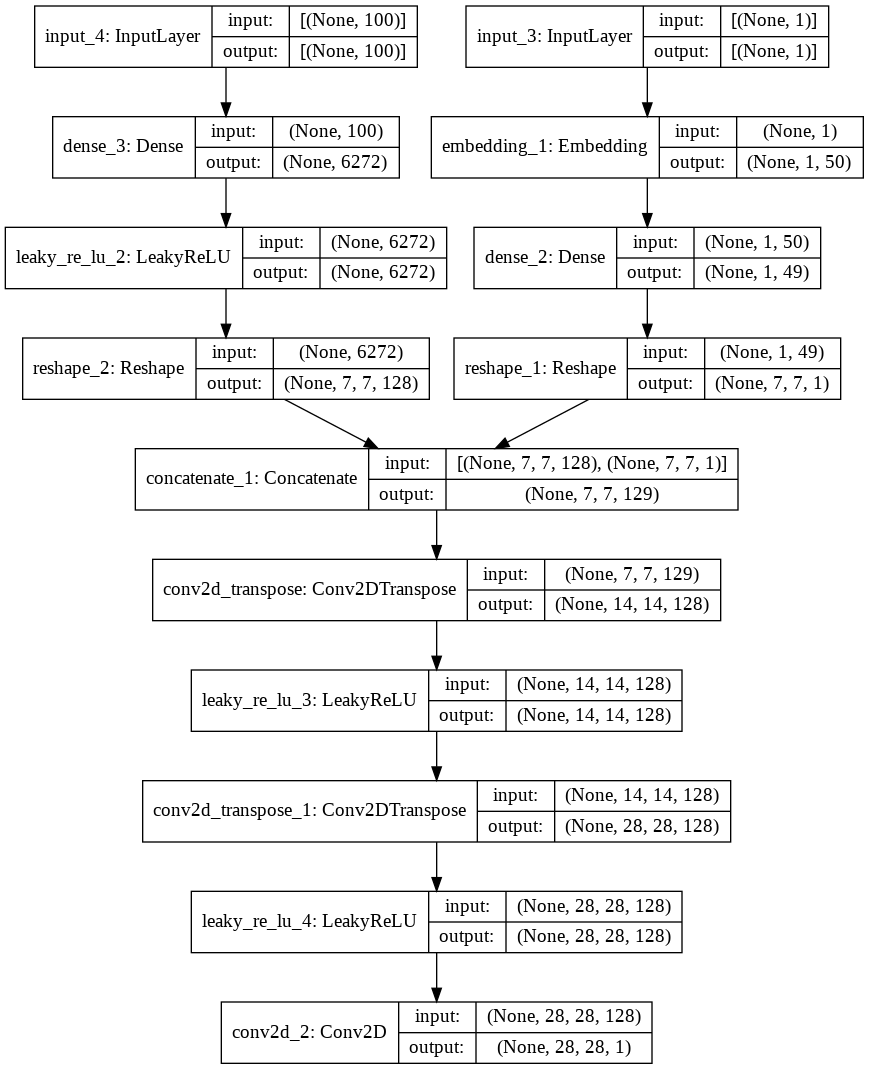

In [12]:
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# cGAN

cGAN model will take as input (a point in latent space, class label) and generate a prediction of whether input was real or fake, as a normal GAN. It is important that we explicitly connect the image generated output from the generator as well as the class label input, both as input to the discriminator model. This allows the same class label input to flow down into the generator and down into the discriminator.

In [13]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    
    # get noise and label inputs from generator model
    gen_noise, gen_label = generator.input
    # get image output from the generator model
    gen_output = generator.output
    
    # connect image output and label input from generator as inputs to discriminator
    cgan_output = discriminator([gen_output, gen_label])
    
    # define gan model as taking (input noise,input label), and outputting a classification
    cGAN = Model([gen_noise, gen_label], cgan_output)
   
    return cGAN

In [14]:
# create the gan
cGAN = define_gan(generator,discriminator)

# compile model
cGAN.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
cGAN.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

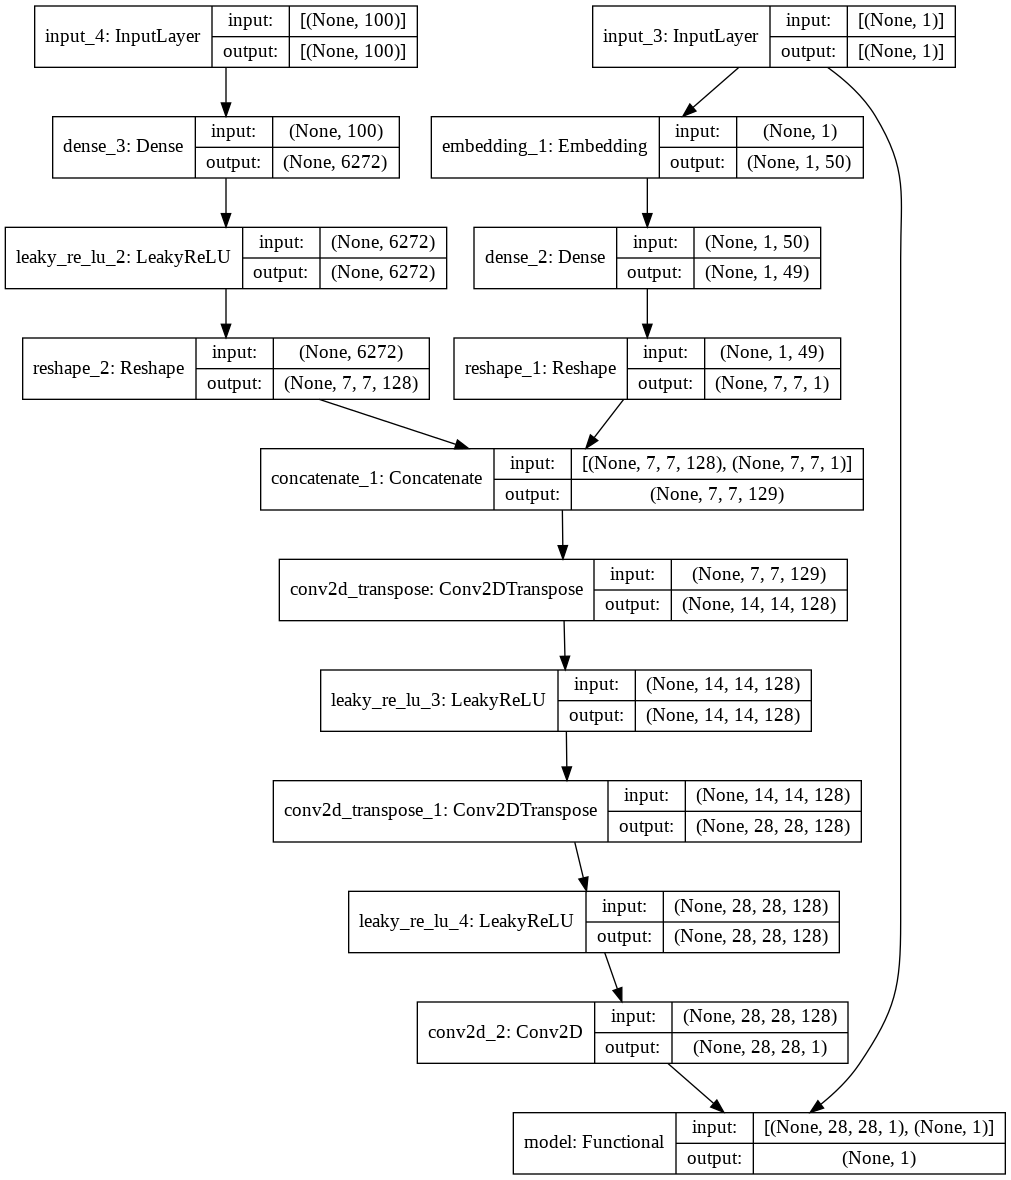

In [15]:
plot_model(cGAN, to_file='cGAN_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
from tensorflow.keras.datasets.fashion_mnist import load_data

# load image data
dataset = load_real_samples()

4423680/4422102 [==============================] - 0s 0us/step


## Training
Use also the class labels in the calls to updating the discriminator and generator models.

In [36]:
# train the generator and discriminator
def train(generator, discriminator, cGAN, dataset, latent_dim=100, n_epochs=25, n_batch=128):

    print("Training:\n")  
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            
            # get randomly selected 'real' samples and update discriminator model weights
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
            
            # generate 'fake' examples and update discriminator model weights
            [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch, n_classes=10)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = cGAN.train_on_batch([z_input, labels_input], y_gan)
            
            # summarize loss on this batch
            if j+1 == bat_per_epo:
                print('>Epoch %d - %d/%d  -\t discr_loss1=%.3f-\t discr_loss2=%.3f-\t gener_loss=%.3f' 
                       %(i+1,  j+1, bat_per_epo,  d_loss1, d_loss2, g_loss))
   
    # save the generator model at the end
    generator.save('cGAN_generator.h5')


In [37]:
latent_dim = 100
train(generator, discriminator, cGAN, dataset)

Training:

>Epoch:1		, 468/468	, discr_loss1=0.634,	 discr_loss2=0.664	 gener_loss=0.834
>Epoch:2		, 468/468	, discr_loss1=0.676,	 discr_loss2=0.680	 gener_loss=0.788
>Epoch:3		, 468/468	, discr_loss1=0.648,	 discr_loss2=0.672	 gener_loss=0.804
>Epoch:4		, 468/468	, discr_loss1=0.681,	 discr_loss2=0.674	 gener_loss=0.803
>Epoch:5		, 468/468	, discr_loss1=0.665,	 discr_loss2=0.637	 gener_loss=0.811
>Epoch:6		, 468/468	, discr_loss1=0.683,	 discr_loss2=0.645	 gener_loss=0.776
>Epoch:7		, 468/468	, discr_loss1=0.723,	 discr_loss2=0.624	 gener_loss=0.871
>Epoch:8		, 468/468	, discr_loss1=0.638,	 discr_loss2=0.669	 gener_loss=0.749
>Epoch:9		, 468/468	, discr_loss1=0.677,	 discr_loss2=0.658	 gener_loss=0.762
>Epoch:10		, 468/468	, discr_loss1=0.675,	 discr_loss2=0.635	 gener_loss=0.810
>Epoch:11		, 468/468	, discr_loss1=0.688,	 discr_loss2=0.666	 gener_loss=0.791
>Epoch:12		, 468/468	, discr_loss1=0.701,	 discr_loss2=0.675	 gener_loss=0.793
>Epoch:13		, 468/468	, discr_loss1=0.658,	 discr_l

## Generate images
Generate images conditional on the class label. We can generate 10 examples for each class label in columns.

In [38]:
from matplotlib import pyplot as plt
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
   
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    
    return [z_input, labels]
 

# create and save a plot of generated images
def draw_plot(examples, n):
    
    # plot images
    for i in range(n * n):
    
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    
    plt.show()

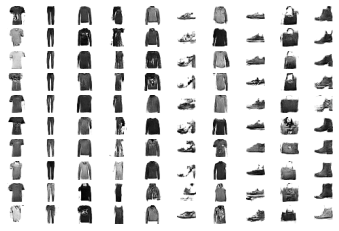

In [39]:
from tensorflow.keras.models import load_model
from numpy import asarray

# load model
model = load_model('cGAN_generator.h5')

# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])

# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
draw_plot(X, 10)

https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/